#  Project: Winning Jeopardy

Jeopardy is a popular TV show in the US where participants answer questions to win money. It's been running for a few decades, and is a major force in popular culture.

Let's say you want to compete on Jeopardy, and you're looking for any edge you can get to win. In this project, you'll work with a dataset of Jeopardy questions to figure out some patterns in the questions that could help you win.

The dataset is named jeopardy.csv, and contains 20000 rows from the beginning of a full dataset of Jeopardy questions, which you can download [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file).

Each row in the dataset represents a single question on a single episode of Jeopardy. Here are explanations of each column:

* Show Number -- the Jeopardy episode number of the show this question was in.
* Air Date -- the date the episode aired.
* Round -- the round of Jeopardy that the question was asked in. Jeopardy has several rounds as each episode progresses.
* Category -- the category of the question.
* Value -- the number of dollars answering the question correctly is worth.
* Question -- the text of the question.
* Answer -- the text of the answer.

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
jeopardy=pd.read_csv("jeopardy.csv")
jeopardy.head(5)

Show Number    Air Date      Round                         Category  Value  \
0         4680  2004-12-31  Jeopardy!                          HISTORY   $200   
1         4680  2004-12-31  Jeopardy!  ESPN's TOP 10 ALL-TIME ATHLETES   $200   
2         4680  2004-12-31  Jeopardy!      EVERYBODY TALKS ABOUT IT...   $200   
3         4680  2004-12-31  Jeopardy!                 THE COMPANY LINE   $200   
4         4680  2004-12-31  Jeopardy!              EPITAPHS & TRIBUTES   $200   

                                            Question      Answer  
0  For the last 8 years of his life, Galileo was ...  Copernicus  
1  No. 2: 1912 Olympian; football star at Carlisl...  Jim Thorpe  
2  The city of Yuma in this state has a record av...     Arizona  
3  In 1963, live on "The Art Linkletter Show", th...  McDonald's  
4  Signer of the Dec. of Indep., framer of the Co...  John Adams

In [3]:
# Remove the spaces in the column name
col_clean=[]
for i in range(len(jeopardy.columns)):
    col_clean.append(jeopardy.columns[i].strip())
jeopardy.columns=col_clean
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [4]:
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 7 columns):
Show Number    19999 non-null int64
Air Date       19999 non-null object
Round          19999 non-null object
Category       19999 non-null object
Value          19999 non-null object
Question       19999 non-null object
Answer         19999 non-null object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


##  Normalizing text
Before you can start doing analysis on the Jeopardy questions, you need to normalize all of the text columns (the Question and Answer columns). We covered normalization before, but the idea is to ensure that you lowercase words and remove punctuation so Don't and don't aren't considered to be different words when you compare them.

In [5]:
def clean_text(text):
    text = re.sub("[^A-Za-z0-9\s]", "", text)
    text = re.sub("\s+", " ", text)
    text=text.lower()
    return text

# Test
clean_text('Or the last 8 years of his life, Galileo was')

'or the last 8 years of his life galileo was'

In [6]:
jeopardy['clean_question'] =jeopardy['Question'].apply(clean_text)
jeopardy['clean_answer']=jeopardy['Answer'].apply(clean_text)

## Normalizing columns
The Value column should also be numeric, to allow you to manipulate it more easily. You'll need to remove the dollar sign from the beginning of each value and convert the column from text to numeric.

The Air Date column should also be a datetime, not a string, to enable you to work with it more easily.

In [7]:
def clean_value(value):
    value=re.sub("[^A-Za-z0-9\s]",' ',value)
    try:
        value=int(value)
    except Exception:
        value=0
    return value

# Test
clean_value('$200')

200

In [8]:
jeopardy['clean_value']=jeopardy['Value'].apply(clean_value)

In [9]:
jeopardy['Air Date']=pd.to_datetime(jeopardy['Air Date'])

In [10]:
jeopardy.dtypes

Show Number                int64
Air Date          datetime64[ns]
Round                     object
Category                  object
Value                     object
Question                  object
Answer                    object
clean_question            object
clean_answer              object
clean_value                int64
dtype: object

## Answers in questions
In order to figure out whether to study past questions, study general knowledge, or not study it all, it would be helpful to figure out two things:

* How often the answer is deducible from the question.
* How often new questions are repeats of older questions.

You can answer the second question by seeing how often complex words (> 6 characters) reoccur. You can answer the first question by seeing how many times words in the answer also occur in the question. We'll work on the first question now, and come back to the second.

In [11]:
def match_QA(row):
    split_answer=row['clean_answer'].split()
    split_question=row['clean_question'].split()

    # 'The' doesn't have any meaningful use in finding the answer
    if "the" in split_answer:
        split_answer.remove("the")
    if len(split_answer) == 0:
        return 0
    
    match_count=0
    for item in split_answer:
        if (item in split_question) and (len(item)>1):
            match_count += 1
    return match_count/len(split_answer)

In [12]:
jeopardy['answer_in_question']=jeopardy.apply(match_QA,axis=1) #axis=1 apply the function across each row

In [13]:
pd.set_option('display.max_colwidth', -1)
jeopardy[['clean_question','clean_answer','answer_in_question']][jeopardy['answer_in_question']>0].iloc[:10]

clean_question  \
14   on june 28 1994 the natl weather service began issuing this index that rates the intensity of the suns radiation   
24   this asian political party was founded in 1885 with indian national as part of its name                            
38   during the 19541955 sun sessions elvis climbed aboard this train sixteen coaches long                              
53   in 1961 james brown announced all aboard for this train                                                            
68   this island in the south pacific is named for the day of its discovery a religious holiday                         
80   the family history you wrote for school might include entering the us at this island in new york bay               
112  hes the older son of prince charles and the late princess diana                                                    
114  falcon heene who it turned out was safe at home not flying over colorado became known as this boy                  
117  prime minister tony blair dubbed her the peoples princess                                                          
122  well look smart in these vehicles that returned to london in 1999                                                  

           clean_answer  answer_in_question  
14   the uv index        0.5                 
24   the congress party  0.5                 
38   the mystery train   0.5                 
53   night train         0.5                 
68   easter island       0.5                 
80   ellis island        0.5                 
112  prince william      0.5                 
114  the balloon boy     0.5                 
117  princess diana      0.5                 
122  trams smart         0.5

In [14]:
jeopardy['answer_in_question'].mean()*100

4.2533522780035105

We only have, on average, 4.3 % of the answer words which are in the question. Thus, we can conclude that the answer isn't deducible from the question

## Recycled questions
Let's say you want to investigate how often new questions are repeats of older ones. You can't completely answer this, because you only have about 10% of the full Jeopardy question dataset, but you can investigate it at least.

To do this, we'll:

* Sort jeopardy in order of ascending air date.
* Maintain a set called terms_used that will be empty initially.
* Iterate through each row of jeopardy.
* Split clean_question into words, remove any word shorter than 6 characters, and check if each word occurs in terms_used.
    * If it does, increment a counter.
    * Add each word to terms_used.

In [15]:
question_overlap=[]
terms_used=set()

jeopardy_sorted=jeopardy.sort_values(by=['Air Date'])

for i,row in jeopardy.iterrows():
    match_count_2=0
    split_question=row["clean_question"].split(" ")
    split_question=[q for q in split_question if len(q)>5]
    if len(split_question)>0:
        for item in split_question:
            if item in terms_used:
                match_count_2 += 1
            else:
                terms_used.add(item)
        match_count_2/=len(split_question)
    question_overlap.append(match_count_2)

jeopardy['question_overlap']=question_overlap

jeopardy["question_overlap"].mean()

0.6925960057338647

In [16]:
jeopardy[['clean_question','question_overlap']][jeopardy['question_overlap']>0].iloc[:10]

clean_question  \
7   no 8 30 steals for the birmingham barons 2306 steals for the bulls                                              
8   in the winter of 197172 a record 1122 inches of snow fell at rainier paradise ranger station in this state      
12  in 1000 rajaraja i of the cholas battled to take this indian ocean island now known for its tea                 
13  no 1 lettered in hoops football lacrosse at syracuse if you think he couldnt act ask his 11 unclean buddies     
18  karl led the first of these marxist organizational efforts the second one began in 1889                         
24  this asian political party was founded in 1885 with indian national as part of its name                         
26  the kirschner brothers don bill named this ski company for themselves the secondhighest mountain                
32  hes considered the author of the pentateuch which is hard to believe as deuteronomy continues after his death   
35  1 of the 2 born in vermont                                                                                      
37  ali who married this mans daughter fatima is considered by shia muslims to be his true successor                

    question_overlap  
7   0.250000          
8   0.125000          
12  0.200000          
13  0.142857          
18  0.250000          
24  0.250000          
26  0.166667          
32  0.166667          
35  1.000000          
37  0.166667

There is about 70% overlap between terms in new questions and terms in old questions. This only looks at a small set of questions, and it doesn't look at phrases, it looks at single terms. This makes it relatively insignificant, but it does mean that it's worth looking more into the recycling of questions.

## Low value vs high value questions

Let's say we only want to study questions that pertain to high value questions instead of low value questions. This will help us earn more money when you're on Jeopardy.

we can actually figure out which terms correspond to high-value questions using a chi-squared test. We'll first need to narrow down the questions into two categories:

* Low value -- Any row where Value is less than 800.
* High value -- Any row where Value is greater than 800.

We'll then be able to loop through each of the terms from terms_used, and:

* Find the number of low value questions the word occurs in.
* Find the number of high value questions the word occurs in.
* Find the percentage of questions the word occurs in.
* Based on the percentage of questions the word occurs in, find expected counts.
* Compute the chi squared value based on the expected counts and the observed counts for high and low value questions.

In [17]:
def find_value(row):
    if row['clean_value']>800:
        value=1
    else:
        value=0
    return value
jeopardy['high_value']=jeopardy.apply(find_value,axis=1)

We can then find the words with the biggest differences in usage between high and low value questions, by selecting the words with the highest associated chi-squared values. Doing this for all of the words would take a very long time, so we'll just do it for a small sample now.

Randomly pick ten elements of terms_used and append them to a list called comparison_terms

In [18]:
def value_count(word):
    low_count=0
    high_count=0
    for i, row in jeopardy.iterrows():
        split_question_vc=row['clean_question'].split()
        if word in split_question_vc:
            if row['high_value']==1:
                high_count +=1
            else:
                low_count +=1
    return high_count,low_count

In [19]:
from random import choice

terms_used_list = list(terms_used)
comparison_terms = [choice(terms_used_list) for i in range(10)]

comparison_terms

['fifteen',
 'ericas',
 'jesters',
 'broadcaster',
 'maguires',
 'hrefhttpwwwjarchivecommedia20060406j05jpg',
 'haberman',
 'prejudice',
 'londoner',
 'system']

In [20]:
observed_expected = []

for term in comparison_terms:
    observed_expected.append(value_count(term))

# (high, low)    
observed_expected

[(0, 2),
 (0, 1),
 (0, 1),
 (1, 3),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 4),
 (0, 1),
 (20, 57)]

## Applying the chi-squared test
The chi-squared test enables us to quantify the difference between sets of observed and expected categorical values to determine statistical significance.

To calculate the chi-squared test statistic, we use the following formula ([more syntax information](https://medium.com/analytics-vidhya/writing-math-equations-in-jupyter-notebook-a-naive-introduction-a5ce87b9a214)): 
$
\frac{(observed − expected)^2}{expected}
$

A p-value allows us to determine whether the difference between two values is due to chance, or due to an A p-value allows us to determine whether the difference between two values is due to chance, or due to an underlying difference. difference.

Now that we've found the observed counts for a few terms (see the previous point), we can compute the expected counts and the chi-squared value.

The expected value for each cell is:
$
\frac {row Total * column Total}{overallTotal}
$

In [21]:
from scipy.stats import chisquare

# Find the number of rows for high and low value
high_value_count=sum(jeopardy['high_value']==1)
low_value_count=sum(jeopardy['high_value']==0)
total_value_count=len(jeopardy)

chi_squared=[]

# Compute the expected counts
for value in observed_expected:
    observed_high_value=value[0]
    observed_low_value=value[1]
    
    total=observed_high_value+observed_low_value
    total_prop=total/total_value_count
    
    expected_high_value=total_prop * high_value_count
    expected_low_value=total_prop * low_value_count
    
    observed = np.array([observed_high_value,observed_low_value])
    expected = np.array([expected_high_value,expected_low_value])
    print(observed)
    
#     chisquare_value, pvalue = chisquare(observed, expected)
#     chi_squared.append((chisquare_value,pvalue))
    chi_squared.append(chisquare(observed, expected))

chi_squared

[0 2]
[0 1]
[0 1]
[1 3]
[0 1]
[0 1]
[0 1]
[0 4]
[0 1]
[20 57]


[Power_divergenceResult(statistic=0.661742197378053, pvalue=0.4159455550913672),
 Power_divergenceResult(statistic=0.3308710986890265, pvalue=0.565146603267378),
 Power_divergenceResult(statistic=0.3308710986890265, pvalue=0.565146603267378),
 Power_divergenceResult(statistic=4.122707846712507e-05, pvalue=0.9948769527982859),
 Power_divergenceResult(statistic=0.3308710986890265, pvalue=0.565146603267378),
 Power_divergenceResult(statistic=0.3308710986890265, pvalue=0.565146603267378),
 Power_divergenceResult(statistic=0.3308710986890265, pvalue=0.565146603267378),
 Power_divergenceResult(statistic=1.323484394756106, pvalue=0.24996766692297967),
 Power_divergenceResult(statistic=0.3308710986890265, pvalue=0.565146603267378),
 Power_divergenceResult(statistic=0.051041658255832886, pvalue=0.8212605233532021)]

In [22]:
#chi_squared_list=[chi for (chi,p) in chi_squared]
pvalue_list=[p for (chi,p) in chi_squared]
pvalue_list

[0.4159455550913672,
 0.565146603267378,
 0.565146603267378,
 0.9948769527982859,
 0.565146603267378,
 0.565146603267378,
 0.565146603267378,
 0.24996766692297967,
 0.565146603267378,
 0.8212605233532021]

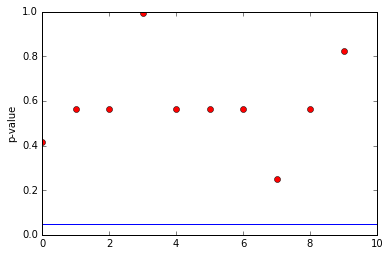

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(10),pvalue_list,'ro',label='p-value')
plt.ylabel('p-value')
plt.hlines(0.05,0,10,'blue',label='p-value threshold')
plt.show()

## Chi-squared results
None of the terms had a significant difference in usage between high value and low value rows. Additionally, the frequencies were all lower than 5, so the chi-squared test [isn't as valid](https://www.researchgate.net/post/What_is_meant_by_this_assumption_of_Chi-Square_test). It would be better to run this test with only terms that have higher frequencies.

## Next steps:

* Find a better way to eliminate non-informative words than just removing words that are less than 6 characters long. Some ideas:
    * Manually create a list of words to remove, like the, than, etc.
    * Find a list of stopwords to remove.
    * Remove words that occur in more than a certain percentage (like 5%) of questions.
* Perform the chi-squared test across more terms to see what terms have larger differences. This is hard to do currently because the code is slow, but here are some ideas:
    * Use the apply method to make the code that calculates frequencies more efficient.
    * Only select terms that have high frequencies across the dataset, and ignore the others.
* Look more into the Category column and see if any interesting analysis can be done with it. Some ideas:
    * See which categories appear the most often.
    * Find the probability of each category appearing in each round.
* Use the whole Jeopardy dataset (available [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file)) instead of the subset we used in this mission.
* Use phrases instead of single words when seeing if there's overlap between questions. Single words don't capture the whole context of the question well.

In [24]:
# question_overlap = []
# terms_used = set()

# jeopardy = jeopardy.sort_values("Air Date")

# for i, row in jeopardy.iterrows():
#         split_question = row["clean_question"].split(" ")
#         split_question = [q for q in split_question if len(q) > 5]
#         match_count = 0
#         for word in split_question:
#             if word in terms_used:
#                 match_count += 1
#         for word in split_question:
#             terms_used.add(word)
#         if len(split_question) > 0:
#             match_count /= len(split_question)
#         question_overlap.append(match_count)
# jeopardy["question_overlap"] = question_overlap

# print(len(terms_used))   

# jeopardy["question_overlap"].mean()

In [25]:
# question_overlap=[]
# terms_used=set()

# jeopardy_sorted=jeopardy.sort_values(by=['Air Date'])

# for i,row in jeopardy.iterrows():
#     match_count_2=0
#     split_question=row["clean_question"].split(" ")
#     #split_question=[q for q in split_question if len(q)>5]
#     if len(split_question)>0:
#         for item in split_question:
#             if len(item)>5:
#                 if item in terms_used:
#                     match_count_2 += 1
#                 else:
#                     terms_used.add(item)
#         match_count_2/=len(split_question)
#     question_overlap.append(match_count_2)

# jeopardy['question_overlap']=question_overlap
# print(len(terms_used))  

# jeopardy['question_overlap'].mean()